In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re

import random
import pickle,pprint

from scipy.stats import gamma
from scipy.optimize import minimize

from matplotlib import rc

%matplotlib inline

In [8]:


rc('text', usetex=True)

# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)


## Poisson Process with absolute refractory period

In [9]:
def RHO(tau,nu,d):
    if tau< d:
        return 0 
    else:
        return nu

def S(tau,nu,d):
    if tau <d:
        return 1
    else:
        return np.exp(-nu*(tau-d))
    
def P(tau,nu,d):
    if tau <d:
        return 0
    else:
        return nu*np.exp(-nu*(tau-d))
    
    

In [10]:
def Cnm(n,m,nu,d):
    ln=eigenvalue(n,nu,d)
    lm=eigenvalue(m,nu,d)
    
    if n==m:
        return ln*d*(1+0.5*d*(ln+nu))/(nu*(1+(ln+nu)*d)**2)
    else:
        
        return (ln*(nu+lm))/((ln-lm)*nu*(ln+nu)*(1+d*(lm+nu)))
    

def eigenvalue(n,nu,d):
    return (1/d)*sc.special.lambertw(d*nu*np.exp(nu*d), k=n)-nu

# Non constant input

In [11]:
nu=1
d=2

dt=0.05
tau_max=15
t_max=10

N_sim=int(t_max/dt)
N=int(tau_max/dt)

tau_vec=[(j)*dt for j in range(N+1)]
t_vec=[(j)*dt for j in range(N_sim)]

In [12]:
P_=[P(t,nu,d) for t in tau_vec]
S_=[S(t,nu,d) for t in tau_vec]
RHO_=[RHO(t,nu,d) for t in tau_vec]

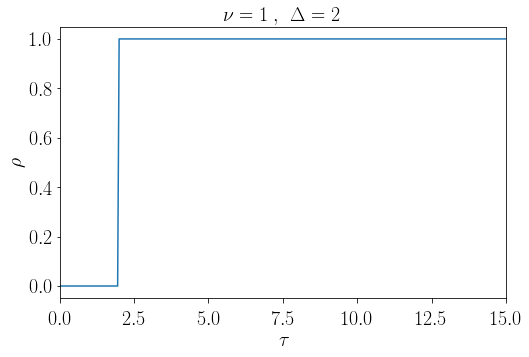

In [13]:
plt.plot(tau_vec,RHO_)
plt.xlabel(r'$\tau')
plt.ylabel(r'$\rho$')
plt.xlim(0,tau_max)

plt.title(r'$ \nu= {}\:,\:\: \Delta={}$'.format(nu,d))

        

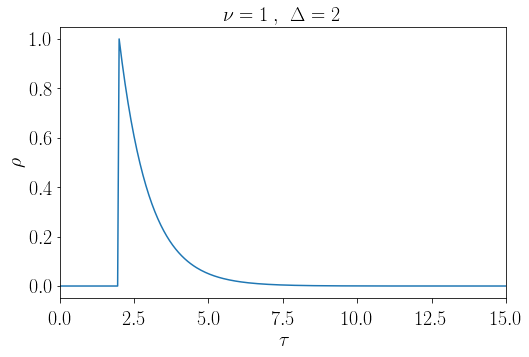

In [14]:
plt.plot(tau_vec,P_)
plt.xlabel(r'$\tau')
plt.ylabel(r'$\rho$')
plt.xlim(0,tau_max)

plt.title(r'$ \nu= {}\:,\:\: \Delta={}$'.format(nu,d))

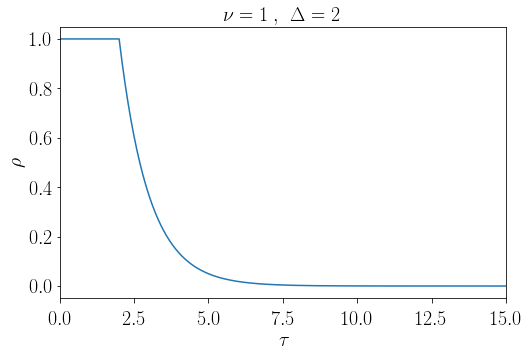

In [15]:


plt.plot(tau_vec,S_)
plt.xlabel(r'$\tau')
plt.ylabel(r'$\rho$')
plt.xlim(0,tau_max)

plt.title(r'$ \nu= {}\:,\:\: \Delta={}$'.format(nu,d))

In [16]:
def eigenvalue(n,nu,d):
    return (1/d)*sc.special.lambertw(d*nu*np.exp(nu*d), k=n)-nu

In [17]:
def psi0phi0(n,nu,d):
    l=eigenvalue(n,nu,d)
    return (nu+l)/(d*(nu+l)+1)

# Non Constante Input   a_1(t)=U+iV

## omega

In [14]:
omega_vec=np.logspace(-1,2, num=30)
err_2_vec=np.zeros(omega_vec.shape)

In [15]:
def err_2(A_n,A_m):
    lenght2=int(len(A_n)/2)
    return  np.sum((A_n[lenght2:]-A_m[lenght2:])**2)/len(A_n[lenght2:])

In [16]:
#MU 
mu_0=1.5
def mu(t):
    return  mu_0


for i_o, omega in enumerate(omega_vec):
    print(i_o)
    #REFRACTORINESS
    d=2

    #TIME PARAMETER
    dt=0.001

    t_max=40
    N_sim=int(t_max/dt)
    tsim=[i*dt for i in range(N_sim)]


    #NU PARAMETER
    beta=0.5
    nu_max=2
    nu_0=nu_max/2


    # H PARMETER
    h=np.zeros((N_sim+1,1))
    h_0=mu_0
    h[0]=h_0
    tau_m=0.9
    epsilon=2
    
    def dnudt(d,i):
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
        h_prime=1/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
        return beta*nu*h_prime/(1+np.exp(beta*(h[i]-h_0)))
    
    A=np.zeros((N_sim,1))

    l1=eigenvalue(1,nu_0,d)
    phi1_0=(nu_0+l1)/(1+d*(nu_0+l1))
    
    U=np.zeros((N_sim+1,1))
    U[0]=-phi1_0.imag

    V=np.zeros((N_sim+1,1))
    V[0]=-phi1_0.real


    for i in range(N_sim):
        t=i*dt
    
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
    
        l1=eigenvalue(1,nu,d)
        phi1_0= (nu+l1)/(1+d*(nu+l1))

    
        A_inf=nu/(d*nu+1)
    
    
        f=(l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*dnudt(d,i))
        g=(l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*dnudt(d,i))
    
    
        c10=Cnm(1,0,nu,d)*dnudt(d,i)
    
        K1=(f.real*U[i]-g.imag*V[i]+c10.real)
        L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
        K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
        L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
        K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
        L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
        K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
        L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
        U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
        V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
        A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
    #integral    
    tsim_num=[i*dt for i in range(N_sim)]

    h=np.zeros((N_sim+1,1))
    h[0]=h_0

    A_wc=np.zeros((N_sim,1))
    A_wc[0]=nu_0/(1+d*nu_0)


    for i in range(N_sim-1):
    
        t=i*dt
    
        jstart=int(np.floor((t-d)/dt))
    
        if jstart<0:
            jstart=0
    
      
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
    
        nu=nu_max/(1+np.exp(-beta*(h[i+1]-h_0)))
    
        A_wc[i+1]=nu*(1-np.sum(A_wc[jstart:i+1]*dt))
    
    #plt.figure()
    #plt.plot(tsim,A,label='$A_{ODE}$')
    #plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
    #plt.legend()
    #plt.ylabel('A')
    #plt.xlabel('t')
    
    
    err_2_vec[i_o]=err_2(A_wc,A)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [17]:
omega_search = {'omega_vec': omega_vec,
                'err_2_vec': err_2_vec
              }

output = open('omega_search.pkl', 'wb')

pickle.dump(omega_search , output)

output.close()

In [18]:
pkl_file = open('omega_search.pkl', 'rb')

omega_search = pickle.load(pkl_file)

pkl_file.close()

omega_vec=omega_search['omega_vec']
err_2_vec=omega_search['err_2_vec']

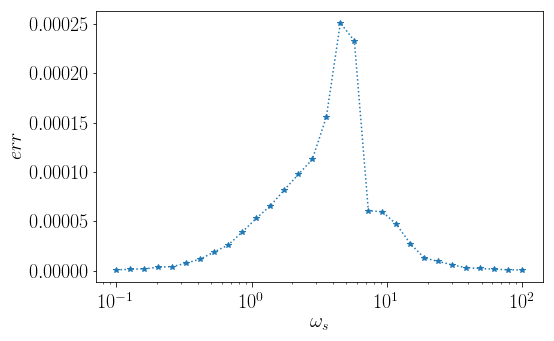

In [19]:
plt.semilogx(omega_vec,err_2_vec,marker='*',ls=':')
plt.xlabel(r'$\omega_s$')
plt.ylabel(r'$err$')


## epsilon

In [277]:
#epsilon_vec=np.linspace(0.1,50, num=10)
epsilon_vec=np.copy([1,2,5,10,20,40,80,160])

err_2_vec=np.zeros(epsilon_vec.shape)

In [278]:
#MU 
mu_0=1.5
def mu(t):
    return  mu_0


for i_o, epsilon in enumerate(epsilon_vec):
    print(i_o)
    #REFRACTORINESS
    d=2

    #TIME PARAMETER
    dt=0.001

    t_max=40
    N_sim=int(t_max/dt)
    tsim=[i*dt for i in range(N_sim)]


    #NU PARAMETER
    beta=0.5
    nu_max=2
    nu_0=nu_max/2


    # H PARMETER
    h=np.zeros((N_sim+1,1))
    h_0=mu_0
    h[0]=h_0
    tau_m=0.9
    omega=10
    
    def dnudt(d,i):
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
        h_prime=1/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
        return beta*nu*h_prime/(1+np.exp(beta*(h[i]-h_0)))
    
    A=np.zeros((N_sim,1))

    l1=eigenvalue(1,nu_0,d)
    phi1_0=(nu_0+l1)/(1+d*(nu_0+l1))
    
    U=np.zeros((N_sim+1,1))
    U[0]=-phi1_0.imag

    V=np.zeros((N_sim+1,1))
    V[0]=-phi1_0.real


    for i in range(N_sim):
        t=i*dt
    
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
    
        l1=eigenvalue(1,nu,d)
        phi1_0= (nu+l1)/(1+d*(nu+l1))

    
        A_inf=nu/(d*nu+1)
    
    
        f=(l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*dnudt(d,i))
        g=(l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*dnudt(d,i))
    
    
        c10=Cnm(1,0,nu,d)*dnudt(d,i)
    
        K1=(f.real*U[i]-g.imag*V[i]+c10.real)
        L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
        K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
        L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
        K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
        L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
        K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
        L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
        U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
        V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
        A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
    #integral    
    tsim_num=[i*dt for i in range(N_sim)]

    h=np.zeros((N_sim+1,1))
    h[0]=h_0

    A_wc=np.zeros((N_sim,1))
    A_wc[0]=nu_0/(1+d*nu_0)


    for i in range(N_sim-1):
    
        t=i*dt
    
        jstart=int(np.floor((t-d)/dt))
    
        if jstart<0:
            jstart=0
    
      
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega*i*dt))
    
        nu=nu_max/(1+np.exp(-beta*(h[i+1]-h_0)))
    
        A_wc[i+1]=nu*(1-np.sum(A_wc[jstart:i+1]*dt))
    
    #plt.figure()
    #plt.plot(tsim,A,label='$A_{ODE}$')
    #plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
    #plt.legend()
    #plt.ylabel('A')
    #plt.xlabel('t')
    
    
    err_2_vec[i_o]=err_2(A_wc,A)
    

0
1
2
3
4
5
6
7


In [279]:
epsilon_search = {'epsilon_vec': epsilon_vec,
                'err_2_vec': err_2_vec
              }

output = open('epsilon_search.pkl', 'wb')

pickle.dump(epsilon_search , output)

output.close()

In [280]:
pkl_file = open('epsilon_search.pkl', 'rb')

epsilon_search = pickle.load(pkl_file)

pkl_file.close()

epsilon_vec=epsilon_search['epsilon_vec']
err_2_vec=epsilon_search['err_2_vec']

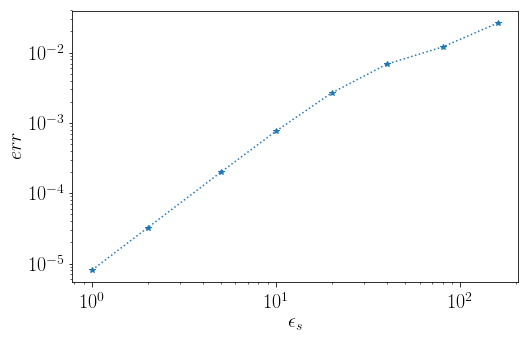

In [283]:
plt.loglog(epsilon_vec,err_2_vec,marker='*',ls=':')
plt.xlabel(r'$\epsilon_s$')
plt.ylabel(r'$err$')


(20, 30)

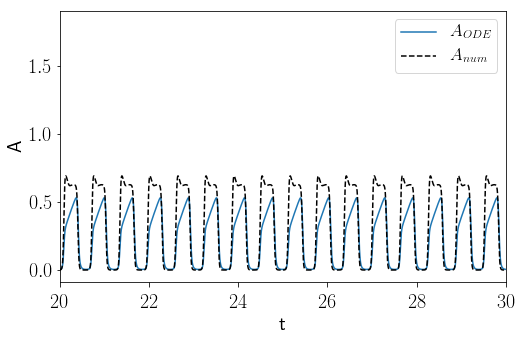

In [285]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('A')
plt.xlabel('t')
plt.xlim(20,30)

In [114]:
#MU 
mu_0=0.5
mu_1=0.5#3

def mu(t):
    if t<50:
        return  mu_0
    else: 
        return  mu_1
    
omega_0=0.1 
omega_1=0.1#2


def omega_t(t):
    if t<30:
        return  omega_1
        
    elif t<70:
        return  omega_0
    else: 
        return  omega_1
    

for io in range(1):
    
    #REFRACTORINESS
    d=2

    #TIME PARAMETER
    dt=0.001

    t_max=90
    N_sim=int(t_max/dt)
    tsim=[i*dt for i in range(N_sim)]


    #NU PARAMETER
    beta=0.5
    nu_max=2
    nu_0=nu_max/2


    # H PARMETER
    h=np.zeros((N_sim+1,1))
    h_0=mu_0
    h[0]=h_0
    tau_m=0.9
    epsilon=1
   
    
    def dnudt(d,i):
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
        h_prime=1/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
        return beta*nu*h_prime/(1+np.exp(beta*(h[i]-h_0)))
    
    A=np.zeros((N_sim,1))

    l1=eigenvalue(1,nu_0,d)
    phi1_0=(nu_0+l1)/(1+d*(nu_0+l1))
    
    U=np.zeros((N_sim+1,1))
    U[0]=0#phi1_0.imag

    V=np.zeros((N_sim+1,1))
    V[0]=0#phi1_0.real


    for i in range(N_sim):
        t=i*dt
    
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
    
        l1=eigenvalue(1,nu,d)
        phi1_0= (nu+l1)/(1+d*(nu+l1))

    
        A_inf=nu/(d*nu+1)
    
    
        f=(l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*dnudt(d,i))
        g=(l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*dnudt(d,i))
    
    
        c10=Cnm(1,0,nu,d)*dnudt(d,i)
    
        K1=(f.real*U[i]-g.imag*V[i]+c10.real)
        L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
        K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
        L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
        K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
        L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
        K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
        L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
        U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
        V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
        A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
    #integral    
    tsim_num=[i*dt for i in range(N_sim)]

    h=np.zeros((N_sim+1,1))
    h[0]=h_0

    
    A_wc_0=nu_0/(1+d*nu_0)
    A_wc=np.zeros((N_sim,1))
    A_wc[0]=A_wc_0


    for i in range(N_sim-1):
    
        t=i*dt
    
        jstart=int(np.floor((t-d)/dt))
    
        if jstart<0:
            term=-jstart
            jstart=0
        else:
            term=0
    
      
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
    
        nu=nu_max/(1+np.exp(-beta*(h[i+1]-h_0)))
    
        A_wc[i+1]=nu*(1-(np.sum(A_wc[jstart:i+1]*dt)+term*A_wc_0*dt))
    
  


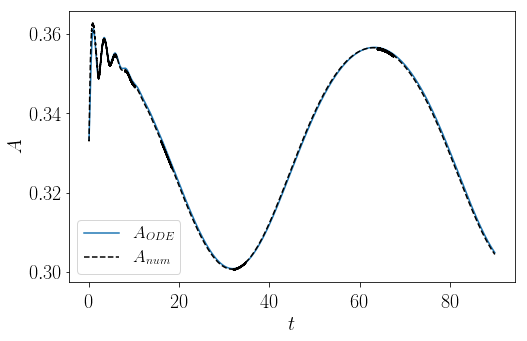

In [115]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
    

(20, 40)

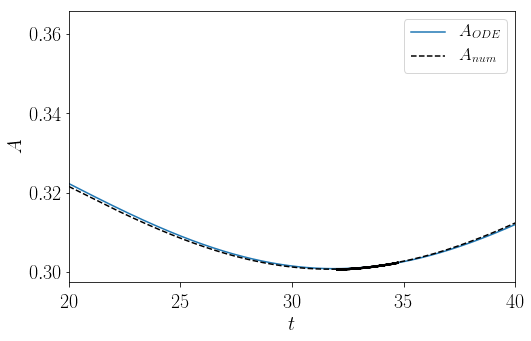

In [116]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
plt.xlim(20,40)

(40, 60)

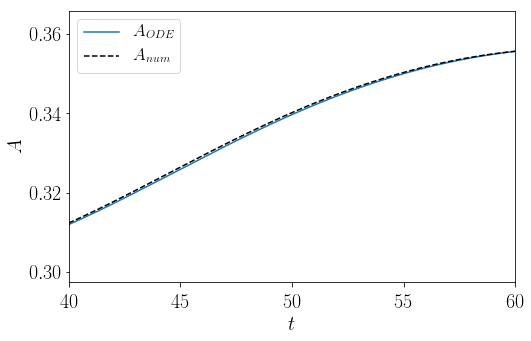

In [117]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
plt.xlim(40,60)

(60, 80)

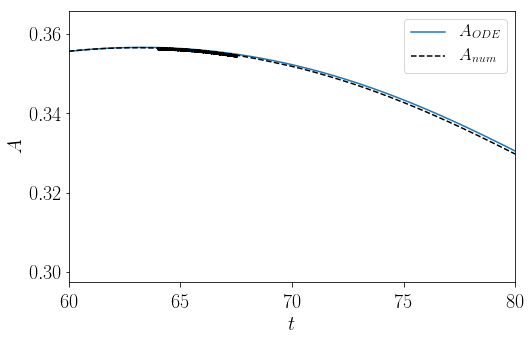

In [118]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
plt.xlim(60,80)

In [124]:
#MU 
mu_0=0.5
mu_1=0.5#3

def mu(t):
    if t<50:
        return  mu_0
    else: 
        return  mu_1
    
omega_0=0.1 
omega_1=0.1#2


def omega_t(t):
    if t<30:
        return  omega_1
        
    elif t<70:
        return  omega_0
    else: 
        return  omega_1
    

for io in range(1):
    
    #REFRACTORINESS
    d=10

    #TIME PARAMETER
    dt=0.001

    t_max=90
    N_sim=int(t_max/dt)
    tsim=[i*dt for i in range(N_sim)]


    #NU PARAMETER
    beta=0.5
    nu_max=2
    nu_0=nu_max/2


    # H PARMETER
    h=np.zeros((N_sim+1,1))
    h_0=mu_0
    h[0]=h_0
    tau_m=10
    epsilon=0
   
    
    def dnudt(d,i):
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
        h_prime=1/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
        return beta*nu*h_prime/(1+np.exp(beta*(h[i]-h_0)))
    
    A=np.zeros((N_sim,1))

    l1=eigenvalue(1,nu_0,d)
    phi1_0=(nu_0+l1)/(1+d*(nu_0+l1))
    
    U=np.zeros((N_sim+1,1))
    U[0]=0#phi1_0.imag

    V=np.zeros((N_sim+1,1))
    V[0]=0#phi1_0.real


    for i in range(N_sim):
        t=i*dt
    
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
        nu=nu_max/(1+np.exp(-beta*(h[i]-h_0)))
    
        l1=eigenvalue(1,nu,d)
        phi1_0= (nu+l1)/(1+d*(nu+l1))

    
        A_inf=nu/(d*nu+1)
    
    
        f=(l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*dnudt(d,i))
        g=(l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*dnudt(d,i))
    
    
        c10=Cnm(1,0,nu,d)*dnudt(d,i)
    
        K1=(f.real*U[i]-g.imag*V[i]+c10.real)
        L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
        K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
        L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
        K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
        L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
        K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
        L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
        U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
        V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
        A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
    #integral    
    tsim_num=[i*dt for i in range(N_sim)]

    h=np.zeros((N_sim+1,1))
    h[0]=h_0

    
    A_wc_0=nu_0/(1+d*nu_0)
    A_wc=np.zeros((N_sim,1))
    A_wc[0]=A_wc_0


    for i in range(N_sim-1):
    
        t=i*dt
    
        jstart=int(np.floor((t-d)/dt))
    
        if jstart<0:
            term=-jstart
            jstart=0
        else:
            term=0
    
      
        h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+epsilon*np.cos(omega_t(i*dt)*i*dt))
    
        nu=nu_max/(1+np.exp(-beta*(h[i+1]-h_0)))
        print(nu)
    
        A_wc[i+1]=nu*(1-(np.sum(A_wc[jstart:i+1]*dt)+term*A_wc_0*dt))
    
  


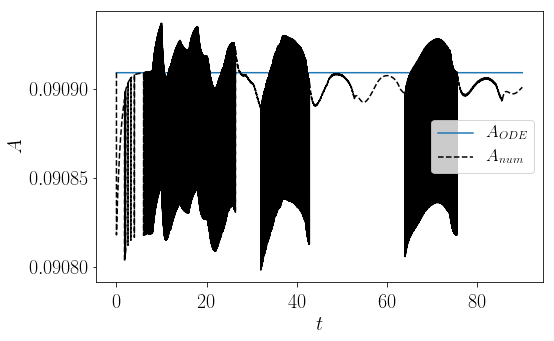

In [125]:
plt.figure()
plt.plot(tsim,A,label='$A_{ODE}$')
plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
    

## ONE POPULATION

In [18]:
def phih(h,nu_max,beta):
    return nu_max/(1+np.exp(-beta*(h-h_0)))

def phih_prime(h,hprime,nu_max,beta):
    return beta*phih(h,nu_max,beta)*hprime/(1+np.exp(beta*(h-h_0)))


In [19]:
def hprime(h,tau_m,J,A_inf,U,V,phi1_0,t):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    
def f(l1,nu,d,nu_max,beta,h,hhprime):
    return l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*phih_prime(h,hhprime,nu_max,beta)

def g(l1,nu,d,nu_max,beta,h,hhprime):
    return l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*phih_prime(h,hhprime,nu_max,beta)
       

def c10(nu,d,nu_max,beta,h,hhprime):
    return Cnm(1,0,nu,d)*phih_prime(h,hhprime,nu_max,beta)

def KLM(h,U,V,tau_m,J,d,nu_max,beta,t):
    
    nu=phih(h,nu_max,beta)
    
    l1=eigenvalue(1,nu,d)
    
    phi1_0= (nu+l1)/(1+d*(nu+l1))

    A_inf=nu/(d*nu+1)
    
    hhp=hprime(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    ff=f(l1,nu,d,nu_max,beta,h,hhp)
    gg=g(l1,nu,d,nu_max,beta,h,hhp)
    cc=c10(nu,d,nu_max,beta,h,hhp)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    
    return K_,L_,M_


def K(f,g,c,U,V):
    
    return (f.real*U-g.imag*V+c.real)

def L(f,g,c,U,V):
    return (g.real*V+f.imag*U+c.imag) 

def M(h,tau_m,J,A_inf,U,V,phi1_0,t):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    

In [50]:
#REFRACTORINESS
d=2

#TIME PARAMETER
dt=0.1

t_max=100
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]

# H PARMETER
h_0=1
tau_m=10
J=1000

#NU PARAMETER 
beta=0.5
nu_max=1
nu_0=nu_max/2

#MU 
mu_0=-100
mu_1=-1
def mu(t):
    if t<30:
        return  mu_0
    else:
        return  mu_1
    
    

In [51]:
A=np.zeros((N_sim,1))

U=np.zeros((N_sim+1,1))
U[0]=1

V=np.zeros((N_sim+1,1))
V[0]=0

h=np.zeros((N_sim+1,1))
h[0]=h_0

for i in range(N_sim):
    t=i*dt
    
    K1,L1,M1=KLM((h[i]),(U[i]),(V[i]),tau_m,J,d,nu_max,beta,t)
    
    K2,L2,M2=KLM((h[i]+0.5*dt*M1),(U[i]+0.5*dt*K1),(V[i]+0.5*dt*L1),tau_m,J,d,nu_max,beta,t)
        
    K3,L3,M3=KLM((h[i]+0.5*dt*M2),(U[i]+0.5*dt*K2),(V[i]+0.5*dt*L2),tau_m,J,d,nu_max,beta,t)
    
    K4,L4,M4=KLM((h[i]+dt*M3),(U[i]+dt*K3),(V[i]+dt*L3),tau_m,J,d,nu_max,beta,t)
    
    
    U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
    V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
    h[i+1]=h[i]+dt/6*(M1+2*M2+2*M3+M4)
    
    
    nu=phih(h[i],nu_max,beta)
    l1=eigenvalue(1,nu,d)
    phi1_0= (nu+l1)/(1+d*(nu+l1))
    A_inf=nu/(d*nu+1)
    
    
    A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
   

### integral formulation

In [52]:
dt=0.01

N_sim=int(t_max/dt)
tsim_num=[i*dt for i in range(N_sim)]

h=np.zeros((N_sim+1,1))
h[0]=h_0

A_wc=np.zeros((N_sim,1))
A_wc[0]=1/dt


for i in range(N_sim-1):
    
    t=i*dt
    
    jstart=int(np.floor((t-d)/dt))
    
    if jstart<0:
        jstart=0
    
      
    h[i+1]=h[i]+dt/tau_m*(-h[i]+mu(i*dt)+J*A_wc[i])
    
    nu=nu_max/(1+np.exp(-beta*(h[i+1]-h_0)))
    
    
    A_wc[i+1]=nu*(1-np.sum(A_wc[jstart:i+1]*dt))

(-0.1, 1)

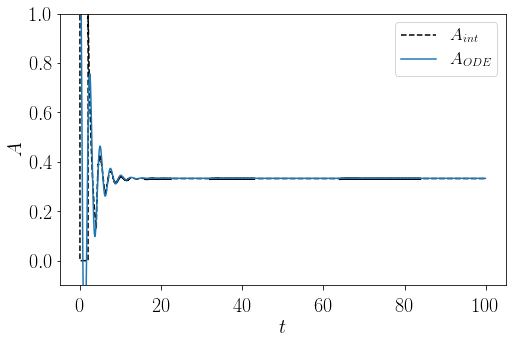

In [53]:
plt.figure()
plt.plot(tsim_num,A_wc,label='$A_{int}$',ls='--',c='k')
plt.plot(tsim,A,label='$A_{ODE}$',ls='-')

plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
plt.ylim(-0.1,1)

## INHIBITORY AND EXITATORY POPULATION

In [52]:
def phih(h,nu_max,beta):
    return nu_max/(1+np.exp(-beta*(h-h_0)))

def phih_prime(h,hprime,nu_max,beta):
    return beta*phih(h,nu_max,beta)*hprime/(1+np.exp(beta*(h-h_0)))

In [111]:
#REFRACTORINESS
d_in=5
d_ex=5

#TIME PARAMETER
dt=0.1

tau_max=50
N=int(tau_max/dt)

t_max=30
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]


# H  ex PARMETER
h_ex=np.zeros((N_sim+1,1))
h_0_ex=1
h_ex[0]=h_0_ex
tau_m_ex=10
J_ex=10
J_exin=20

# H in  PARMETER
h_in=np.zeros((N_sim+1,1))
h_0_in=1
h_in[0]=h_0_in
tau_m_in=10
J_in=-10
J_inex=-20



#NU PARAMETER ex
beta_ex=0.2
nu_max_ex=1
nu_0_ex=nu_max_ex/2


#NU PARAMETER in 
beta_in=0.5
nu_max_in=1
nu_0_in=nu_max_in/2



In [112]:
def hprime(h,tau_m,J,A_inf,U,V,phi1_0,J_el,A_inf_el,U_el,V_el,phi1_0_el):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ J_el/tau_m*(A_inf_el +2*(U_el*phi1_0_el.real-V_el*phi1_0_el.imag))
    
def f(l1,nu,d,nu_max,beta,h,hhprime):
    return l1+(Cnm(1,1,nu,d)+Cnm(1,-1,nu,d))*phih_prime(h,hhprime,nu_max,beta)

def g(l1,nu,d,nu_max,beta,h,hhprime):
    return l1+(Cnm(1,1,nu,d)-Cnm(1,-1,nu,d))*phih_prime(h,hhprime,nu_max,beta)
       

def c10(nu,d,nu_max,beta,h,hhprime):
    return Cnm(1,0,nu,d)*phih_prime(h,hhprime,nu_max,beta)

def KLM(h,U,V,tau_m,J,d,nu_max,beta,h_el,U_el,V_el,J_el,d_el,nu_max_el,beta_el):
    
    nu=phih(h,nu_max,beta)
    nu_el=phih(h_el,nu_max_el,beta_el)
    
    l1=eigenvalue(1,nu,d)
    l1_el=eigenvalue(1,nu_el,d_el)
    
    phi1_0= (nu+l1)/(1+d*(nu+l1))
    phi1_0_el= (nu_el+l1_el)/(1+d_el*(nu_el+l1_el))

    A_inf=nu/(d*nu+1)
    A_inf_el=nu_el/(d_el*nu_el+1)
    
    
    hhp=hprime(h,tau_m,J,A_inf,U,V,phi1_0,J_el,A_inf_el,U_el,V_el,phi1_0_el)
    
    ff=f(l1,nu,d,nu_max,beta,h,hhp)
    gg=g(l1,nu,d,nu_max,beta,h,hhp)
    cc=c10(nu,d,nu_max,beta,h,hhp)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,J_el,A_inf_el,U_el,V_el,phi1_0_el)
    
    
    return K_,L_,M_


def K(f,g,c,U,V):
    
    return (f.real*U-g.imag*V+c.real)

def L(f,g,c,U,V):
    return (g.real*V+f.imag*U+c.imag) 

def M(h,tau_m,J,A_inf,U,V,phi1_0,J_el,A_inf_el,U_el,V_el,phi1_0_el):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ J_el/tau_m*(A_inf_el +2*(U_el*phi1_0_el.real-V_el*phi1_0_el.imag))
    

In [113]:
A_ex=np.zeros((N_sim,1))
A_in=np.zeros((N_sim,1))

U_ex=np.zeros((N_sim+1,1))
U_ex[0]=1
U_in=np.zeros((N_sim+1,1))
U_in[0]=1

V_ex=np.zeros((N_sim+1,1))
V_ex[0]=0
V_in=np.zeros((N_sim+1,1))
V_in[0]=0

h_ex=np.zeros((N_sim+1,1))
h_ex[0]=h_0_ex
h_in=np.zeros((N_sim+1,1))
h_in[0]=h_0_in


for i in range(N_sim):
    t=i*dt
    
    K1_ex,L1_ex,M1_ex=KLM((h_ex[i]),(U_ex[i]),(V_ex[i]),tau_m_ex,J_ex,d_ex,nu_max_ex,beta_ex,(h_in[i]),(U_in[i]),(V_in[i]),J_inex,d_in,nu_max_in,beta_in)
    K1_in,L1_in,M1_in=KLM((h_in[i]),(U_in[i]),(V_in[i]),tau_m_in,J_in,d_in,nu_max_in,beta_in,(h_ex[i]),(U_ex[i]),(V_ex[i]),J_exin,d_ex,nu_max_ex,beta_ex)
    
    K2_ex,L2_ex,M2_ex=KLM((h_ex[i]+0.5*dt*M1_ex),(U_ex[i]+0.5*dt*K1_ex),(V_ex[i]+0.5*dt*L1_ex),tau_m_ex,J_ex,d_ex,nu_max_ex,beta_ex,(h_in[i]+0.5*dt*M1_in),(U_in[i]+0.5*dt*K1_in),(V_in[i]+0.5*dt*L1_in),J_inex,d_in,nu_max_in,beta_in)
    K2_in,L2_in,M2_in=KLM((h_in[i]+0.5*dt*M1_in),(U_in[i]+0.5*dt*K1_in),(V_in[i]+0.5*dt*L1_in),tau_m_in,J_in,d_in,nu_max_in,beta_in,(h_ex[i]+0.5*dt*M1_ex),(U_ex[i]+0.5*dt*K1_ex),(V_ex[i]+0.5*dt*L1_ex),J_exin,d_ex,nu_max_ex,beta_ex)
        
        
    K3_ex,L3_ex,M3_ex=KLM((h_ex[i]+0.5*dt*M2_ex),(U_ex[i]+0.5*dt*K2_ex),(V_ex[i]+0.5*dt*L2_ex),tau_m_ex,J_ex,d_ex,nu_max_ex,beta_ex,(h_in[i]+0.5*dt*M2_in),(U_in[i]+0.5*dt*K2_in),(V_in[i]+0.5*dt*L2_in),J_inex,d_in,nu_max_in,beta_in)
    K3_in,L3_in,M3_in=KLM((h_in[i]+0.5*dt*M2_in),(U_in[i]+0.5*dt*K2_in),(V_in[i]+0.5*dt*L2_in),tau_m_in,J_in,d_in,nu_max_in,beta_in,(h_ex[i]+0.5*dt*M2_ex),(U_ex[i]+0.5*dt*K2_ex),(V_ex[i]+0.5*dt*L2_ex),J_exin,d_ex,nu_max_ex,beta_ex)  
    
    
    K4_ex,L4_ex,M4_ex=KLM((h_ex[i]+dt*M3_ex),(U_ex[i]+dt*K3_ex),(V_ex[i]+dt*L3_ex),tau_m_ex,J_ex,d_ex,nu_max_ex,beta_ex,(h_in[i]+dt*M3_in),(U_in[i]+dt*K3_in),(V_in[i]+dt*L3_in),J_inex,d_in,nu_max_in,beta_in)
    K4_in,L4_in,M4_in=KLM((h_in[i]+dt*M3_in),(U_in[i]+dt*K3_in),(V_in[i]+dt*L3_in),tau_m_in,J_in,d_in,nu_max_in,beta_in,(h_ex[i]+dt*M3_ex),(U_ex[i]+dt*K3_ex),(V_ex[i]+dt*L3_ex),J_exin,d_ex,nu_max_ex,beta_ex)

    
    
    U_ex[i+1]=U_ex[i]+dt/6*(K1_ex+2*K2_ex+2*K3_ex+K4_ex)
    V_ex[i+1]=V_ex[i]+dt/6*(L1_ex+2*L2_ex+2*L3_ex+L4_ex)
    h_ex[i+1]=h_ex[i]+dt/6*(M1_ex+2*M2_ex+2*M3_ex+M4_ex)
    
    U_in[i+1]=U_in[i]+dt/6*(K1_in+2*K2_in+2*K3_in+K4_in)
    V_in[i+1]=V_in[i]+dt/6*(L1_in+2*L2_in+2*L3_in+L4_in)
    h_in[i+1]=h_in[i]+dt/6*(M1_in+2*M2_in+2*M3_in+M4_in)
    
    
    nu_ex=phih(h_ex[i],nu_max_ex,beta_ex)
    l1_ex=eigenvalue(1,nu_ex,d_ex)
    phi1_0_ex= (nu_ex+l1_ex)/(1+d_ex*(nu_ex+l1_ex))
    A_inf_ex=nu_ex/(d_ex*nu_ex+1)
    
    
    nu_in=phih(h_in[i],nu_max_in,beta_in)
    l1_in=eigenvalue(1,nu_in,d_in)
    phi1_0_in= (nu_in+l1_in)/(1+d_in*(nu_in+l1_in))
    A_inf_in=nu_in/(d_in*nu_in+1)
         
    
    A_ex[i]=A_inf_ex+2*(U_ex[i]*phi1_0_ex.real-V_ex[i]*phi1_0_ex.imag)
    A_in[i]=A_inf_in+2*(U_in[i]*phi1_0_in.real-V_in[i]*phi1_0_in.imag)

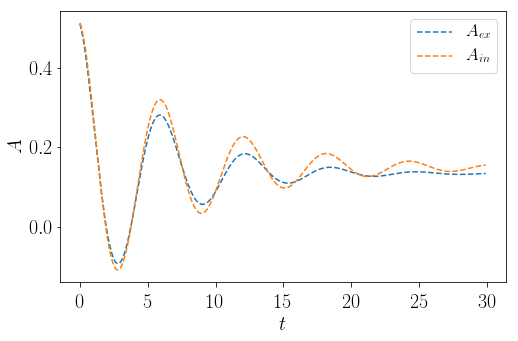

In [114]:
plt.figure()
plt.plot(tsim,A_ex,label='$A_{ex}$',ls='--')
plt.plot(tsim,A_in,label='$A_{in}$',ls='--')
plt.legend()
plt.ylabel('$A$')
plt.xlabel('$t$')
    